# Week 4 Homework
## Titanic: From Data Exploration to Advanced Imputation & Boosting

**Workflow:**
1.  **Exploratory Data Analysis (EDA):** Visualize correlations and survival patterns.
2.  **Feature Engineering:** Extract titles, create family stats, and **encode categorical variables**.
3.  **Smart Imputation:** Train a Regressor to predict missing ages (vs. simple median filling).
4.  **Model Zoo:** Benchmark 5 Tree-based models (Decision Tree, RF, AdaBoost, XGBoost, LightGBM).
5.  **Optimization:** Tune hyperparameters and interpret Feature Importance.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url = 'https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Titanic_train.csv'
df = pd.read_csv(url)
print(df.head())
print(df.describe())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

## Part 1: Exploratory Data Analysis (EDA)

1.  **Missing Data Visualization:** Use a heatmap or bar chart to visualize where data is missing.

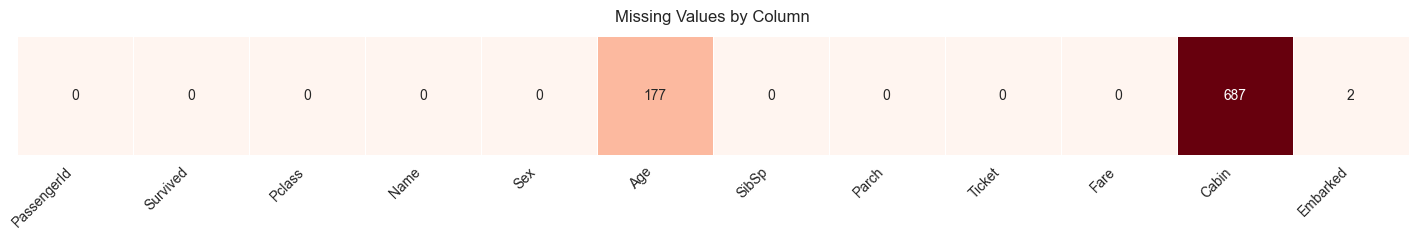

In [20]:
na_counts = df.isna().sum().to_frame(name="Missing values").T

plt.figure(figsize=(1.2 * len(df.columns), 2.5))

sns.heatmap(
    na_counts,
    annot=True,
    fmt="d",
    cmap="Reds",
    linewidths=0.5,
    linecolor="white",
    cbar=False,
    annot_kws={"size": 10}
)

plt.xticks(rotation=45, ha="right")
plt.yticks([])
plt.title("Missing Values by Column", fontsize=12, pad=10)

plt.tight_layout()
plt.show()

2.  **Survival Analysis:** Plot the survival rate by `Sex`, `Pclass`, `Parch`, `SibSp`, and `Embarked` and give comments.


- **Sex:** Survival rates differ sharply by sex. Females show higher survival probability than males, reflecting the “women and children first” evacuation procedure.

- **Class:** Survival decreases steadily from first to third class. This shows socioeconomic stratification: first-class passengers had  faster access to lifeboats, and preferential treatment during evacuation.

- **Parch:** There is no clear trend with respect to the number of parents or children regarding survival rates. There is indication that moderate family presence likely facilitated mutual help.

- **SibSp:** Survival is highest for passengers traveling with one sibling or spouse and declines as family size increases. Small family units benefit from cooperation, whereas larger groups experience higher evacuation issues.

- **Embarked:** Passengers embarking at Cherbourg have the highest survival rate, while those from Southampton have the lowest. This effect primarily reflects differences in passenger composition, as Cherbourg passengers were more likely to be wealthier and travel in higher classes.

**Main Takeaways:** Survival on the Titanic was driven by a combination of **demographic factors (sex)**, **socioeconomic status (class and fare)**, and **family structure**, with small family units and higher-class passengershaving survival advantages.

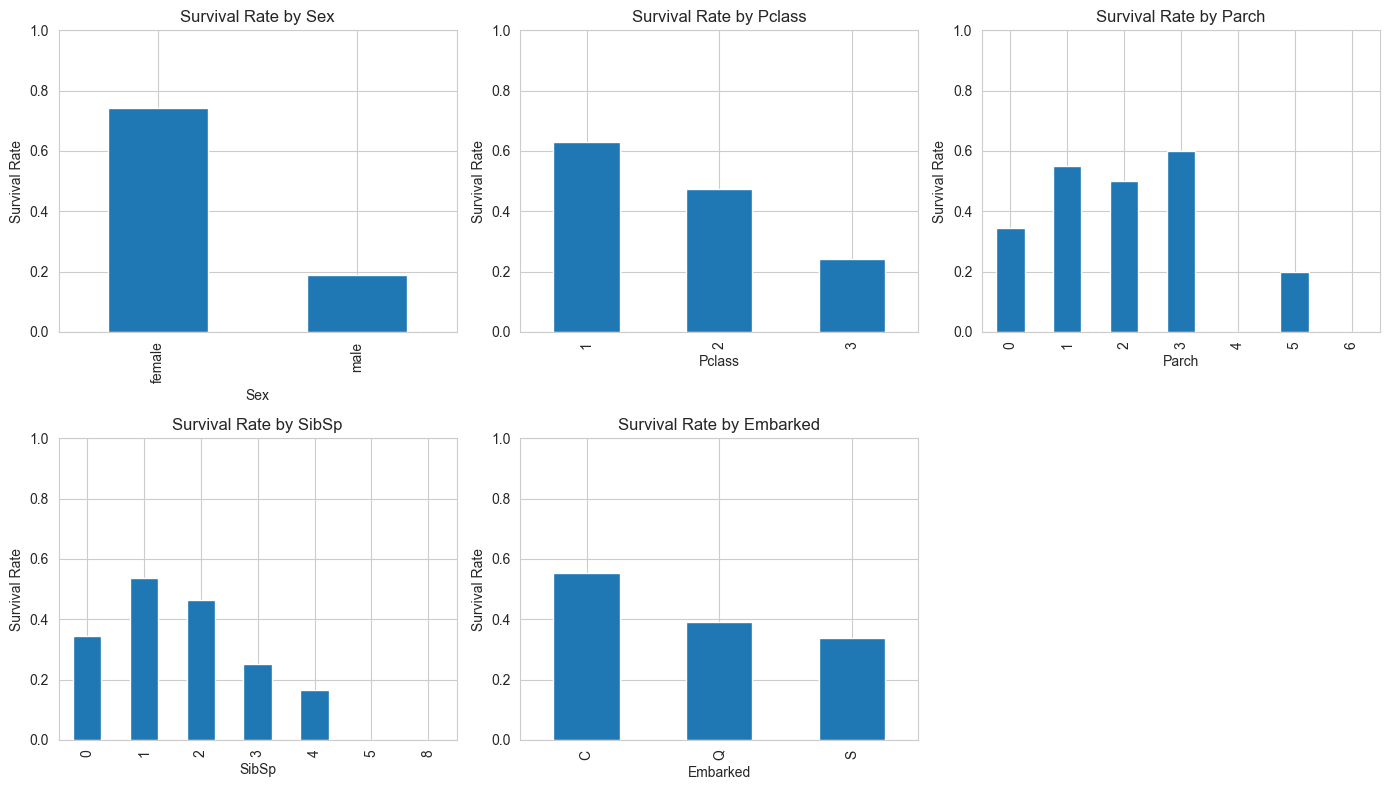

In [27]:
import matplotlib.pyplot as plt

cat_vars = ["Sex", "Pclass", "Parch", "SibSp", "Embarked"]

plt.figure(figsize=(14, 8))

for i, var in enumerate(cat_vars, 1):
    plt.subplot(2, 3, i)
    df.groupby(var)["Survived"].mean().plot(kind="bar", ylim=(0, 1))
    plt.title(f"Survival Rate by {var}")
    plt.ylabel("Survival Rate")
    plt.xlabel(var)

plt.tight_layout()
plt.show()


3.  **Correlation Matrix:** Calculate and plot the correlation between numerical features (`Age`, `Fare`, `Parch`, `SibSp`, `Survived`).
    * *Question: Which features correlate with Survival?
    * **A:** As expected, `Age` has a negative correlation with survival, although of very low magnitude, whereas `Fare` has a modestly positive value. `Parch` and `SibsSp` both show low magnitude correlation, the former being positive and the latter negative.

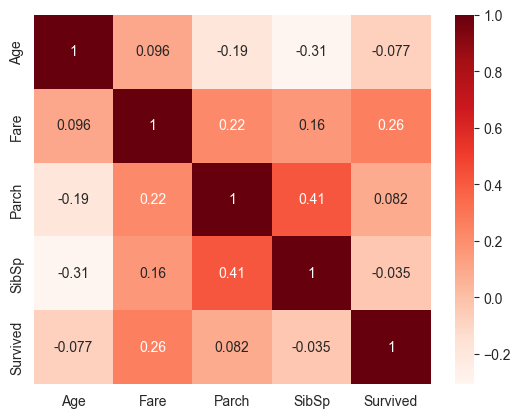

In [31]:
df_num = df[['Age', 'Fare', 'Parch', 'SibSp', 'Survived']]

sns.heatmap(df_num.corr(), cmap="Reds", annot=True,)
plt.show()

## Part 2: Feature Engineering & Encoding

Machine Learning models generally require numerical input. We also want to extract hidden information from text columns.

In [48]:
df["Title"] = df["Name"].str.extract(r",\s*([^\.]+)\.")

common_titles = ["Mr", "Mrs", "Miss", "Master"]


df["Title"] = df["Title"].where(df["Title"].isin(common_titles), "Rare")

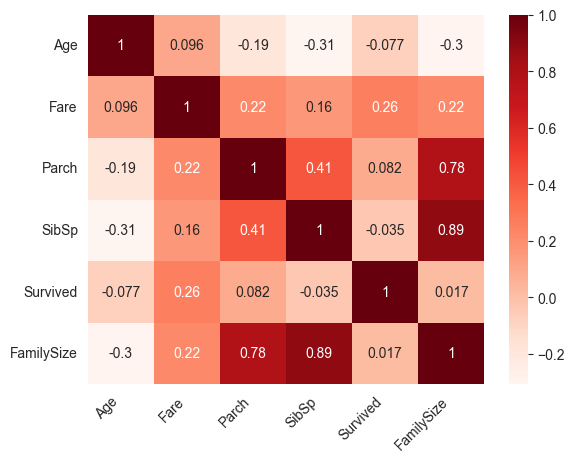

In [46]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

df_num_n = df[['Age', 'Fare', 'Parch', 'SibSp', 'Survived', 'FamilySize']]

sns.heatmap(df_num_n.corr(), cmap="Reds", annot=True,)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0, ha="right")
plt.show()

In [49]:
df = df.drop(columns=["Name", "Ticket", "Cabin", "SibSp", "Parch"])

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   Fare         891 non-null    float64
 6   Embarked     889 non-null    object 
 7   FamilySize   891 non-null    int64  
 8   Title        891 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


One-Hot Encoding is used because the categorical variables have no intrinsic order. Label Encoding would introduce spurious ordinal relationships that could bias coefficient-based models.

In [51]:
df = pd.get_dummies(df, columns=["Sex", "Embarked", "Title"], drop_first=True)

## Part 3: Advanced Imputation (The Regression Task)

We have missing values in `Age`. Instead of filling them with the median, we will predict them.

**Task:**
1.  **Create Two Datasets:**
    * `df_median`: Copy original `df` and fill `Age` with the median.
    * `df_model`: Copy original `df` but keep `Age` missing for now.
2.  **Train a Regressor:**
    * Split `df_model` into rows with known Age (Train) and unknown Age (Predict).
    * Train a **Random Forest Regressor** using `Pclass`, `Title`, `Fare`, `FamilySize` to predict `Age`.
    * Fill the missing values in `df_model` with your predictions.
3.  **Compare Distributions:** Plot the KDE (Kernel Density Estimate) of `Age` for both methods and the original dataset (before filling). Which one preserves the original distribution shape better?

In [52]:
df_median = df.copy()
df_median["Age"] = df_median["Age"].fillna(df_median["Age"].median())

df_model = df.copy()

In [54]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'Fare', 'FamilySize',
       'Sex_male', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Rare'],
      dtype='object')

In [55]:
from sklearn.ensemble import RandomForestRegressor

features = ["Pclass", "Fare", "FamilySize", 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']

df_model_reg = pd.get_dummies(df_model[features], drop_first=True)

X_train = df_model_reg[df_model["Age"].notna()]
y_train = df_model.loc[df_model["Age"].notna(), "Age"]

X_pred = df_model_reg[df_model["Age"].isna()]

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

age_pred = rf.predict(X_pred)

df_model.loc[df_model["Age"].isna(), "Age"] = age_pred

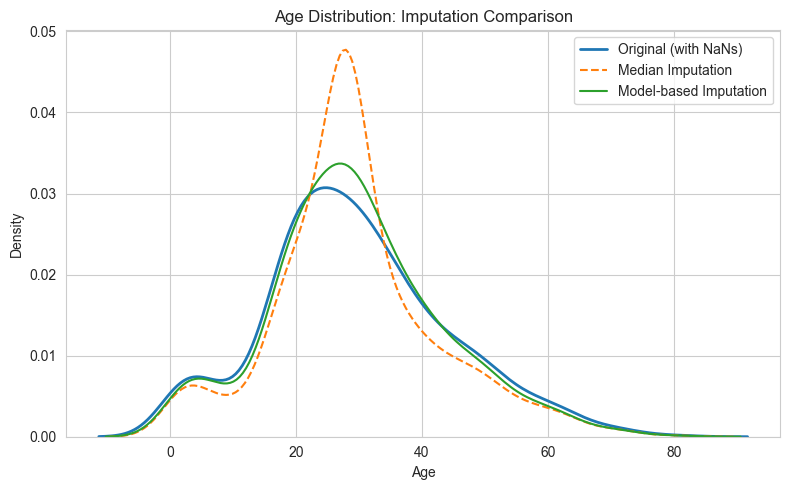

In [56]:
plt.figure(figsize=(8, 5))

sns.kdeplot(df["Age"], label="Original (with NaNs)", linewidth=2)
sns.kdeplot(df_median["Age"], label="Median Imputation", linestyle="--")
sns.kdeplot(df_model["Age"], label="Model-based Imputation")

plt.title("Age Distribution: Imputation Comparison")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

## Part 4: The Model Zoo (Classification Benchmark)

Now we use the cleaned data to predict survival.

In [57]:
from sklearn.model_selection import train_test_split

X = df_model.drop(columns=["Survived"])
y = df_model["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="logloss"
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=200,
        learning_rate=0.1,
        random_state=42
    )
}

In [ ]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    })

In [62]:
results_df = (
    pd.DataFrame(results)
    .sort_values(by="Accuracy", ascending=False)
    .reset_index(drop=True)
)

results_df

,Model,Accuracy,F1-Score
0,Random Forest,0.804469,0.732824
1,AdaBoost,0.793296,0.737589
2,XGBoost,0.793296,0.717557
3,LightGBM,0.776536,0.701493
4,Decision Tree,0.765363,0.700000
